# Random Forest Classifier - Predicting Future Stock Price

In [71]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [72]:
# Read in stock historical prices and calculate daily return
stock_prices = pd.read_csv("../Resources/stock_historical_prices.csv")
stock_prices = stock_prices.set_index("Date")
stock_prices.dropna(inplace=True)
stock_prices.head()

,Adj Close
Date,
2015-03-18,186.609985
2015-03-19,185.758835
2015-03-20,187.398468
2015-03-23,187.033279
2015-03-24,185.982346


In [73]:
# Drop NAs and calculate daily percent return
stock_prices['Daily_Return'] = stock_prices['Adj Close'].dropna().pct_change()
stock_prices.head()

,Adj Close,Daily_Return
Date,,
2015-03-18,186.609985,NaN
2015-03-19,185.758835,-0.004561
2015-03-20,187.398468,0.008827
2015-03-23,187.033279,-0.001949
2015-03-24,185.982346,-0.005619


In [74]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
stock_prices['Fast_Close'] = stock_prices['Adj Close'].ewm(halflife=short_window).mean()
stock_prices['Slow_Close'] = stock_prices['Adj Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
stock_prices['Crossover_Long'] = np.where(stock_prices['Fast_Close'] > stock_prices['Slow_Close'], 1.0, 0.0)
stock_prices['Crossover_Short'] = np.where(stock_prices['Fast_Close'] < stock_prices['Slow_Close'], -1.0, 0.0)
stock_prices['Crossover_Signal'] = stock_prices['Crossover_Long'] + stock_prices['Crossover_Short']

stock_prices.tail()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal
Date,,,,,,,
2021-03-15,395.115906,0.005964,393.004649,385.082510,1.0,0.0,1.0
2021-03-16,394.617523,-0.001261,393.811086,385.721042,1.0,0.0,1.0
2021-03-17,395.963135,0.003410,394.887110,386.406924,1.0,0.0,1.0
2021-03-18,390.201996,-0.014550,392.544553,386.661069,1.0,0.0,1.0
2021-03-19,389.480011,-0.001850,391.012282,386.849845,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

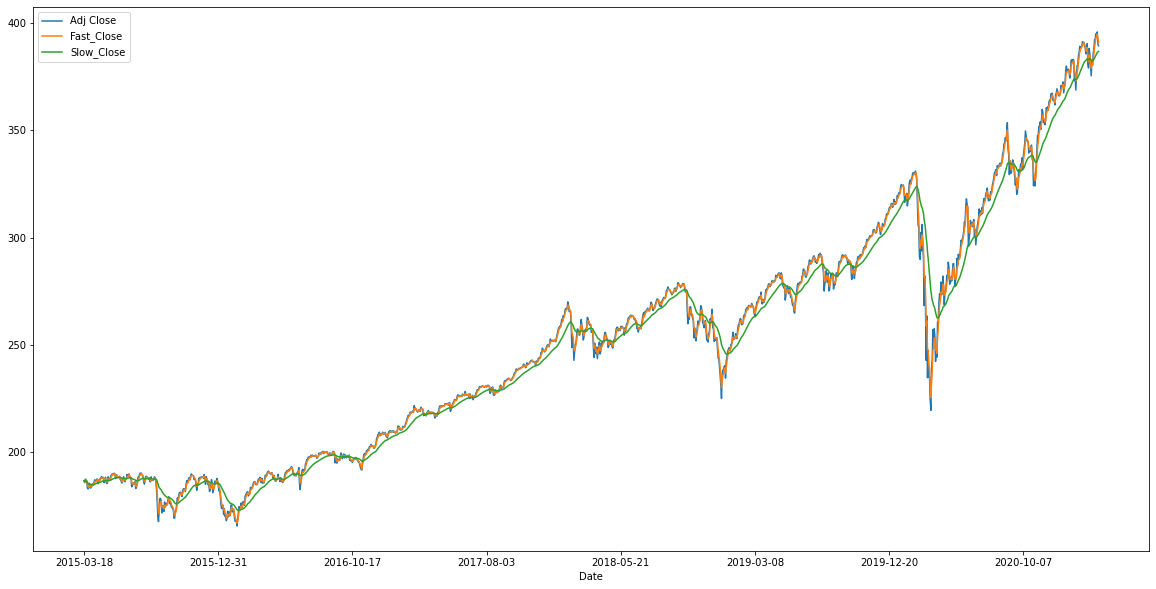

In [75]:
# Plot EMA
stock_prices[['Adj Close', 'Fast_Close', 'Slow_Close']].plot(figsize=(20,10))

In [76]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
stock_prices['Fast_Vol'] = stock_prices['Daily_Return'].ewm(halflife=short_vol_window).std()
stock_prices['Slow_Vol'] = stock_prices['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
stock_prices['Vol_Trend_Long'] = np.where(stock_prices['Fast_Vol'] < stock_prices['Slow_Vol'], 1.0, 0.0)
stock_prices['Vol_Trend_Short'] = np.where(stock_prices['Fast_Vol'] > stock_prices['Slow_Vol'], -1.0, 0.0) 
stock_prices['Vol_Trend_Signal'] = stock_prices['Vol_Trend_Long'] + stock_prices['Vol_Trend_Short']

stock_prices.head()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal
Date,,,,,,,,,,,,
2015-03-18,186.609985,NaN,186.609985,186.609985,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2015-03-19,185.758835,-0.004561,186.042552,186.169667,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2015-03-20,187.398468,0.008827,186.817361,186.607963,1.0,0.0,1.0,0.009467,0.009467,0.0,0.0,0.0
2015-03-23,187.033279,-0.001949,186.932517,186.725589,1.0,0.0,1.0,0.006852,0.007048,1.0,0.0,1.0
2015-03-24,185.982346,-0.005619,186.442106,186.555654,0.0,-1.0,-1.0,0.006032,0.006562,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

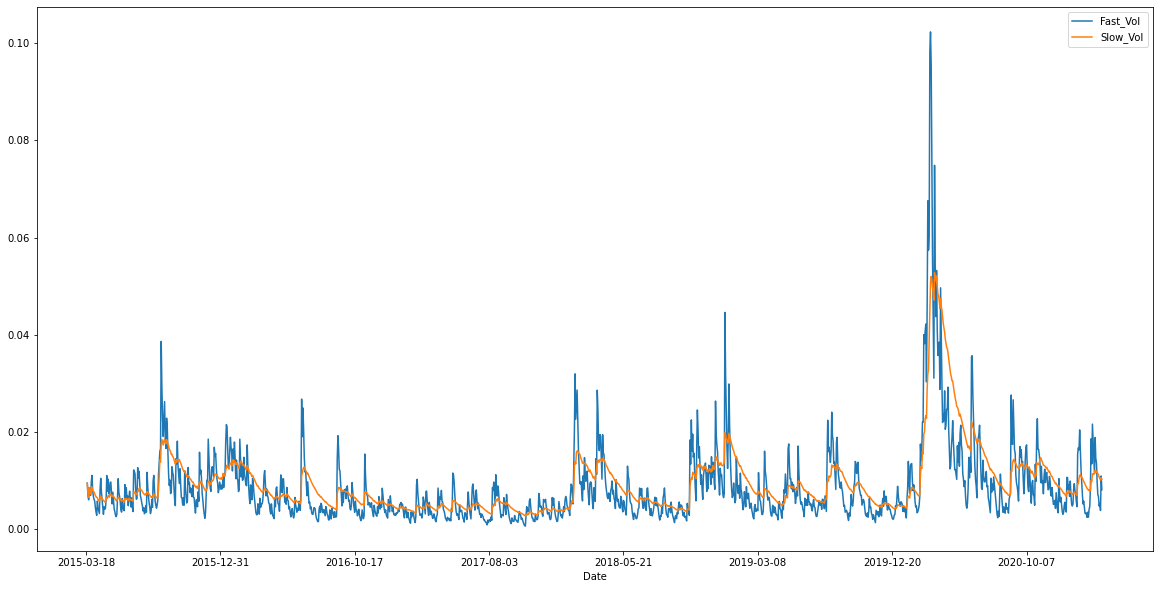

In [77]:
# Plot EMA volatility
stock_prices[['Fast_Vol', 'Slow_Vol']].plot(figsize=(20,10))

In [78]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
stock_prices['Bollinger_Mid_Band'] = stock_prices['Adj Close'].rolling(window=bollinger_window).mean()
stock_prices['Bollinger_Std'] = stock_prices['Adj Close'].rolling(window=bollinger_window).std()

# Calculate upper and lowers bands of bollinger band
stock_prices['Bollinger_Upper_Band']  = stock_prices['Bollinger_Mid_Band'] + (stock_prices['Bollinger_Std'] * 1)
stock_prices['Bollinger_Lower_Band']  = stock_prices['Bollinger_Mid_Band'] - (stock_prices['Bollinger_Std'] * 1)

# Calculate bollinger band trading signal
stock_prices['Bollinger_Long'] = np.where(stock_prices['Adj Close'] < stock_prices['Bollinger_Lower_Band'], 1.0, 0.0)
stock_prices['Bollinger_Short'] = np.where(stock_prices['Adj Close'] > stock_prices['Bollinger_Upper_Band'], -1.0, 0.0)
stock_prices['Bollinger_Signal'] = stock_prices['Bollinger_Long'] + stock_prices['Bollinger_Short']

stock_prices.head()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal,Bollinger_Mid_Band,Bollinger_Std,Bollinger_Upper_Band,Bollinger_Lower_Band,Bollinger_Long,Bollinger_Short,Bollinger_Signal
Date,,,,,,,,,,,,,,,,,,,
2015-03-18,186.609985,NaN,186.609985,186.609985,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-03-19,185.758835,-0.004561,186.042552,186.169667,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-03-20,187.398468,0.008827,186.817361,186.607963,1.0,0.0,1.0,0.009467,0.009467,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-03-23,187.033279,-0.001949,186.932517,186.725589,1.0,0.0,1.0,0.006852,0.007048,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2015-03-24,185.982346,-0.005619,186.442106,186.555654,0.0,-1.0,-1.0,0.006032,0.006562,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


<AxesSubplot:xlabel='Date'>

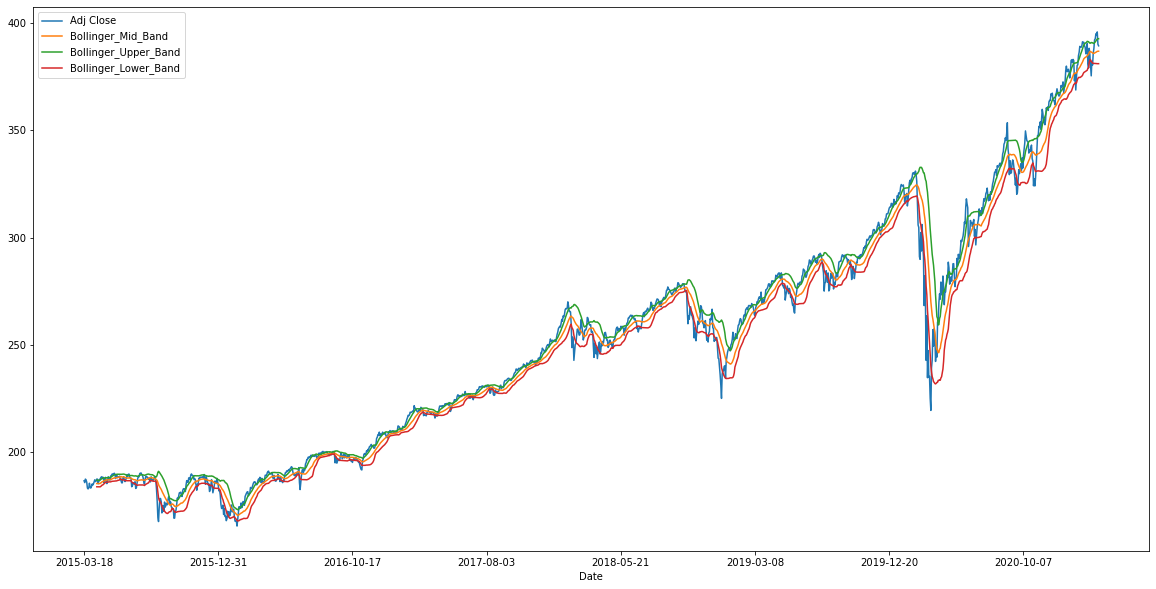

In [79]:
# Plot the Bollinger Bands for closing prices
stock_prices[['Adj Close','Bollinger_Mid_Band','Bollinger_Upper_Band','Bollinger_Lower_Band']].plot(figsize=(20,10))

In [80]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
stock_prices['Positive_Return'] = np.where(stock_prices['Daily_Return'] > 0, 1.0, 0.0)
stock_prices = stock_prices.dropna()
stock_prices.tail()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal,Bollinger_Mid_Band,Bollinger_Std,Bollinger_Upper_Band,Bollinger_Lower_Band,Bollinger_Long,Bollinger_Short,Bollinger_Signal,Positive_Return
Date,,,,,,,,,,,,,,,,,,,,
2021-03-15,395.115906,0.005964,393.004649,385.082510,1.0,0.0,1.0,0.004740,0.010754,1.0,0.0,1.0,386.472707,5.260350,391.733057,381.212357,0.0,-1.0,-1.0,1.0
2021-03-16,394.617523,-0.001261,393.811086,385.721042,1.0,0.0,1.0,0.005286,0.010420,1.0,0.0,1.0,386.652617,5.480940,392.133557,381.171677,0.0,-1.0,-1.0,0.0
2021-03-17,395.963135,0.003410,394.887110,386.406924,1.0,0.0,1.0,0.003826,0.010074,1.0,0.0,1.0,386.895322,5.787561,392.682882,381.107761,0.0,-1.0,-1.0,1.0
2021-03-18,390.201996,-0.014550,392.544553,386.661069,1.0,0.0,1.0,0.010930,0.010584,0.0,-1.0,-1.0,386.933197,5.807565,392.740762,381.125632,0.0,0.0,0.0,0.0
2021-03-19,389.480011,-0.001850,391.012282,386.849845,1.0,0.0,1.0,0.008117,0.010245,1.0,0.0,1.0,386.969362,5.821753,392.791115,381.147609,0.0,0.0,0.0,0.0


In [81]:
X = stock_prices[["Crossover_Signal","Vol_Trend_Signal","Bollinger_Signal"]]
X_train = X[:"2021"]

In [82]:
y = stock_prices["Positive_Return"]
y_train = y[:"2021"]

In [83]:
X_test = X["2021":]
y_test = y["2021":]

In [84]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [85]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [86]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [87]:
# Create the decision tree classifier instance
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# Fit the model
model = model.fit(X_train_scaled, y_train)

In [88]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [89]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [90]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15,8
Actual 1,10,20


Accuracy Score : 0.660377358490566
Classification Report
              precision    recall  f1-score   support

         0.0       0.60      0.65      0.63        23
         1.0       0.71      0.67      0.69        30

    accuracy                           0.66        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.66      0.66      0.66        53



In [93]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive_Return,Predicted Value
Date,,
2021-01-04,0.0,0.0
2021-01-05,1.0,0.0
2021-01-06,1.0,1.0
2021-01-07,1.0,1.0
2021-01-08,1.0,1.0
2021-01-11,0.0,1.0
2021-01-12,1.0,1.0
2021-01-13,1.0,1.0
2021-01-14,0.0,1.0


In [92]:
# Random Forest shows approx. 63% overall accuracy with prediction of negative return and approx. 69% accuracy with prediction of positive return. 

# Maybe varying the length of the series and tweaking model hyperparameters will further improve model accuracy.